# Test Various CNN architectures on the layer identification task


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from Classifier_models import CNN1D_Small, CNN1D_Large, train_model, identify_device

## Import Data 

In [16]:
device = identify_device()

Using device: cuda


In [17]:
# Load the dataset with weights_only=False
data = torch.load("Synthetic_data_60k.pt", weights_only=False)

# Extract components
synthetic_data = data["synthetic_data"]
material_params = data["material_params"]
num_layers = data["num_layers"]

print("Dataset loaded successfully!")
print(f"Number of samples: {len(synthetic_data)}")
print(f"Shape of synthetic_data: {synthetic_data.shape}")
print(f"Shape of num_layers: {num_layers.shape}")
print(f"Example number of layers: {num_layers[:10]}")

num_classes = int(max(num_layers)) # class labels start at 1 not 0.

Dataset loaded successfully!
Number of samples: 60000
Shape of synthetic_data: torch.Size([60000, 1024])
Shape of num_layers: torch.Size([60000])
Example number of layers: tensor([3, 3, 2, 1, 3, 2, 3, 1, 1, 3])


In [18]:
# Adjust labels for training (CrossEntropyLoss expects 0-based class labels)
num_layers_adjusted = num_layers - 1  # Convert labels from 1–5 → 0–4

# Ensure shapes are as expected
print("synthetic_data shape (after unsqueeze):", synthetic_data.unsqueeze(1).shape)
print("num_layers (original):", num_layers[:10])
print("num_layers_adjusted (for training):", num_layers_adjusted[:10])


synthetic_data shape (after unsqueeze): torch.Size([60000, 1, 1024])
num_layers (original): tensor([3, 3, 2, 1, 3, 2, 3, 1, 1, 3])
num_layers_adjusted (for training): tensor([2, 2, 1, 0, 2, 1, 2, 0, 0, 2])


In [19]:
num_classes = int(num_layers_adjusted.max().item()) + 1  # e.g., 5 if max label is 4
batch_size = 1024

# Unsqueeze to add channel dimension for Conv1D input: [B, 1, 1024]
synthetic_data = synthetic_data.unsqueeze(1)  # [100, 1, 1024]

# Create TensorDataset with adjusted labels
train_dataset = TensorDataset(synthetic_data, num_layers_adjusted)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Train and Test Small CNN

In [6]:
# Initialize the model, criterion, and optimizer
model = CNN1D_Small(input_channels=1, num_classes=num_classes).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Optional: Print shapes and label stats for sanity check
print("Data shape:", synthetic_data.shape)
print("Label range:", num_layers_adjusted.min().item(), "to", num_layers_adjusted.max().item())
print("Number of classes:", num_classes)

Data shape: torch.Size([60000, 1, 1024])
Label range: 0 to 2
Number of classes: 3


Epoch 1/200: 100%|██████████| 59/59 [00:01<00:00, 39.30batch/s, loss=1.1]


Epoch [1/200], Loss: 1.1005


Epoch 2/200: 100%|██████████| 59/59 [00:01<00:00, 50.51batch/s, loss=1.1]


Epoch [2/200], Loss: 1.0988


Epoch 3/200: 100%|██████████| 59/59 [00:01<00:00, 45.37batch/s, loss=1.1]


Epoch [3/200], Loss: 1.0980


Epoch 4/200: 100%|██████████| 59/59 [00:01<00:00, 50.38batch/s, loss=1.1]


Epoch [4/200], Loss: 1.0966


Epoch 5/200: 100%|██████████| 59/59 [00:01<00:00, 45.13batch/s, loss=1.09]


Epoch [5/200], Loss: 1.0913


Epoch 6/200: 100%|██████████| 59/59 [00:01<00:00, 50.24batch/s, loss=1.08]


Epoch [6/200], Loss: 1.0759


Epoch 7/200: 100%|██████████| 59/59 [00:01<00:00, 44.69batch/s, loss=1.04]


Epoch [7/200], Loss: 1.0441


Epoch 8/200: 100%|██████████| 59/59 [00:01<00:00, 50.69batch/s, loss=0.998]


Epoch [8/200], Loss: 0.9978


Epoch 9/200: 100%|██████████| 59/59 [00:01<00:00, 44.87batch/s, loss=0.959]


Epoch [9/200], Loss: 0.9594


Epoch 10/200: 100%|██████████| 59/59 [00:01<00:00, 50.48batch/s, loss=0.939]


Epoch [10/200], Loss: 0.9385


Epoch 11/200: 100%|██████████| 59/59 [00:01<00:00, 44.23batch/s, loss=0.93] 


Epoch [11/200], Loss: 0.9302


Epoch 12/200: 100%|██████████| 59/59 [00:01<00:00, 50.52batch/s, loss=0.922]


Epoch [12/200], Loss: 0.9222


Epoch 13/200: 100%|██████████| 59/59 [00:01<00:00, 45.35batch/s, loss=0.918]


Epoch [13/200], Loss: 0.9176


Epoch 14/200: 100%|██████████| 59/59 [00:01<00:00, 50.51batch/s, loss=0.916]


Epoch [14/200], Loss: 0.9160


Epoch 15/200: 100%|██████████| 59/59 [00:01<00:00, 44.83batch/s, loss=0.911]


Epoch [15/200], Loss: 0.9112


Epoch 16/200: 100%|██████████| 59/59 [00:01<00:00, 51.09batch/s, loss=0.909]


Epoch [16/200], Loss: 0.9093


Epoch 17/200: 100%|██████████| 59/59 [00:01<00:00, 45.35batch/s, loss=0.907]


Epoch [17/200], Loss: 0.9070


Epoch 18/200: 100%|██████████| 59/59 [00:01<00:00, 50.48batch/s, loss=0.905]


Epoch [18/200], Loss: 0.9045


Epoch 19/200: 100%|██████████| 59/59 [00:01<00:00, 44.79batch/s, loss=0.903]


Epoch [19/200], Loss: 0.9032


Epoch 20/200: 100%|██████████| 59/59 [00:01<00:00, 51.27batch/s, loss=0.903]


Epoch [20/200], Loss: 0.9032


Epoch 21/200: 100%|██████████| 59/59 [00:01<00:00, 45.40batch/s, loss=0.9]  


Epoch [21/200], Loss: 0.9004


Epoch 22/200: 100%|██████████| 59/59 [00:01<00:00, 51.26batch/s, loss=0.899]


Epoch [22/200], Loss: 0.8989


Epoch 23/200: 100%|██████████| 59/59 [00:01<00:00, 44.87batch/s, loss=0.897]


Epoch [23/200], Loss: 0.8974


Epoch 24/200: 100%|██████████| 59/59 [00:01<00:00, 50.48batch/s, loss=0.896]


Epoch [24/200], Loss: 0.8962


Epoch 25/200: 100%|██████████| 59/59 [00:01<00:00, 45.29batch/s, loss=0.895]


Epoch [25/200], Loss: 0.8953


Epoch 26/200: 100%|██████████| 59/59 [00:01<00:00, 49.86batch/s, loss=0.895]


Epoch [26/200], Loss: 0.8953


Epoch 27/200: 100%|██████████| 59/59 [00:01<00:00, 44.31batch/s, loss=0.893]


Epoch [27/200], Loss: 0.8929


Epoch 28/200: 100%|██████████| 59/59 [00:01<00:00, 49.70batch/s, loss=0.892]


Epoch [28/200], Loss: 0.8922


Epoch 29/200: 100%|██████████| 59/59 [00:01<00:00, 44.91batch/s, loss=0.892]


Epoch [29/200], Loss: 0.8922


Epoch 30/200: 100%|██████████| 59/59 [00:01<00:00, 50.44batch/s, loss=0.89] 


Epoch [30/200], Loss: 0.8905


Epoch 31/200: 100%|██████████| 59/59 [00:01<00:00, 43.75batch/s, loss=0.89] 


Epoch [31/200], Loss: 0.8898


Epoch 32/200: 100%|██████████| 59/59 [00:01<00:00, 50.40batch/s, loss=0.889]


Epoch [32/200], Loss: 0.8887


Epoch 33/200: 100%|██████████| 59/59 [00:01<00:00, 50.65batch/s, loss=0.888]


Epoch [33/200], Loss: 0.8879


Epoch 34/200: 100%|██████████| 59/59 [00:01<00:00, 46.55batch/s, loss=0.886]


Epoch [34/200], Loss: 0.8863


Epoch 35/200: 100%|██████████| 59/59 [00:01<00:00, 49.83batch/s, loss=0.886]


Epoch [35/200], Loss: 0.8856


Epoch 36/200: 100%|██████████| 59/59 [00:01<00:00, 46.54batch/s, loss=0.883]


Epoch [36/200], Loss: 0.8835


Epoch 37/200: 100%|██████████| 59/59 [00:01<00:00, 49.82batch/s, loss=0.883]


Epoch [37/200], Loss: 0.8832


Epoch 38/200: 100%|██████████| 59/59 [00:01<00:00, 45.34batch/s, loss=0.879]


Epoch [38/200], Loss: 0.8788


Epoch 39/200: 100%|██████████| 59/59 [00:01<00:00, 50.55batch/s, loss=0.878]


Epoch [39/200], Loss: 0.8778


Epoch 40/200: 100%|██████████| 59/59 [00:01<00:00, 45.35batch/s, loss=0.877]


Epoch [40/200], Loss: 0.8766


Epoch 41/200: 100%|██████████| 59/59 [00:01<00:00, 49.81batch/s, loss=0.874]


Epoch [41/200], Loss: 0.8738


Epoch 42/200: 100%|██████████| 59/59 [00:01<00:00, 44.58batch/s, loss=0.871]


Epoch [42/200], Loss: 0.8706


Epoch 43/200: 100%|██████████| 59/59 [00:01<00:00, 50.07batch/s, loss=0.868]


Epoch [43/200], Loss: 0.8676


Epoch 44/200: 100%|██████████| 59/59 [00:01<00:00, 44.78batch/s, loss=0.867]


Epoch [44/200], Loss: 0.8667


Epoch 45/200: 100%|██████████| 59/59 [00:01<00:00, 49.81batch/s, loss=0.862]


Epoch [45/200], Loss: 0.8619


Epoch 46/200: 100%|██████████| 59/59 [00:01<00:00, 44.79batch/s, loss=0.86] 


Epoch [46/200], Loss: 0.8601


Epoch 47/200: 100%|██████████| 59/59 [00:01<00:00, 49.82batch/s, loss=0.856]


Epoch [47/200], Loss: 0.8559


Epoch 48/200: 100%|██████████| 59/59 [00:01<00:00, 44.74batch/s, loss=0.854]


Epoch [48/200], Loss: 0.8537


Epoch 49/200: 100%|██████████| 59/59 [00:01<00:00, 50.53batch/s, loss=0.85] 


Epoch [49/200], Loss: 0.8498


Epoch 50/200: 100%|██████████| 59/59 [00:01<00:00, 44.87batch/s, loss=0.846]


Epoch [50/200], Loss: 0.8464


Epoch 51/200: 100%|██████████| 59/59 [00:01<00:00, 50.55batch/s, loss=0.846]


Epoch [51/200], Loss: 0.8460


Epoch 52/200: 100%|██████████| 59/59 [00:01<00:00, 44.20batch/s, loss=0.841]


Epoch [52/200], Loss: 0.8406


Epoch 53/200: 100%|██████████| 59/59 [00:01<00:00, 49.71batch/s, loss=0.838]


Epoch [53/200], Loss: 0.8382


Epoch 54/200: 100%|██████████| 59/59 [00:01<00:00, 44.87batch/s, loss=0.835]


Epoch [54/200], Loss: 0.8353


Epoch 55/200: 100%|██████████| 59/59 [00:01<00:00, 50.49batch/s, loss=0.831]


Epoch [55/200], Loss: 0.8314


Epoch 56/200: 100%|██████████| 59/59 [00:01<00:00, 45.93batch/s, loss=0.829]


Epoch [56/200], Loss: 0.8288


Epoch 57/200: 100%|██████████| 59/59 [00:01<00:00, 51.00batch/s, loss=0.826]


Epoch [57/200], Loss: 0.8262


Epoch 58/200: 100%|██████████| 59/59 [00:01<00:00, 44.94batch/s, loss=0.824]


Epoch [58/200], Loss: 0.8243


Epoch 59/200: 100%|██████████| 59/59 [00:01<00:00, 49.73batch/s, loss=0.822]


Epoch [59/200], Loss: 0.8217


Epoch 60/200: 100%|██████████| 59/59 [00:01<00:00, 44.85batch/s, loss=0.819]


Epoch [60/200], Loss: 0.8190


Epoch 61/200: 100%|██████████| 59/59 [00:01<00:00, 49.72batch/s, loss=0.817]


Epoch [61/200], Loss: 0.8167


Epoch 62/200: 100%|██████████| 59/59 [00:01<00:00, 44.29batch/s, loss=0.814]


Epoch [62/200], Loss: 0.8137


Epoch 63/200: 100%|██████████| 59/59 [00:01<00:00, 49.83batch/s, loss=0.811]


Epoch [63/200], Loss: 0.8112


Epoch 64/200: 100%|██████████| 59/59 [00:01<00:00, 44.79batch/s, loss=0.809]


Epoch [64/200], Loss: 0.8086


Epoch 65/200: 100%|██████████| 59/59 [00:01<00:00, 50.52batch/s, loss=0.806]


Epoch [65/200], Loss: 0.8063


Epoch 66/200: 100%|██████████| 59/59 [00:01<00:00, 44.80batch/s, loss=0.804]


Epoch [66/200], Loss: 0.8042


Epoch 67/200: 100%|██████████| 59/59 [00:01<00:00, 50.52batch/s, loss=0.8]  


Epoch [67/200], Loss: 0.8003


Epoch 68/200: 100%|██████████| 59/59 [00:01<00:00, 49.82batch/s, loss=0.794]


Epoch [68/200], Loss: 0.7944


Epoch 69/200: 100%|██████████| 59/59 [00:01<00:00, 44.77batch/s, loss=0.791]


Epoch [69/200], Loss: 0.7906


Epoch 70/200: 100%|██████████| 59/59 [00:01<00:00, 44.79batch/s, loss=0.777]


Epoch [70/200], Loss: 0.7771


Epoch 71/200: 100%|██████████| 59/59 [00:01<00:00, 49.81batch/s, loss=0.755]


Epoch [71/200], Loss: 0.7545


Epoch 72/200: 100%|██████████| 59/59 [00:01<00:00, 50.55batch/s, loss=0.746]


Epoch [72/200], Loss: 0.7461


Epoch 73/200: 100%|██████████| 59/59 [00:01<00:00, 46.44batch/s, loss=0.73] 


Epoch [73/200], Loss: 0.7301


Epoch 74/200: 100%|██████████| 59/59 [00:01<00:00, 50.64batch/s, loss=0.72] 


Epoch [74/200], Loss: 0.7198


Epoch 75/200: 100%|██████████| 59/59 [00:01<00:00, 45.37batch/s, loss=0.713]


Epoch [75/200], Loss: 0.7128


Epoch 76/200: 100%|██████████| 59/59 [00:01<00:00, 49.81batch/s, loss=0.705]


Epoch [76/200], Loss: 0.7054


Epoch 77/200: 100%|██████████| 59/59 [00:01<00:00, 44.23batch/s, loss=0.694]


Epoch [77/200], Loss: 0.6944


Epoch 78/200: 100%|██████████| 59/59 [00:01<00:00, 49.82batch/s, loss=0.69] 


Epoch [78/200], Loss: 0.6898


Epoch 79/200: 100%|██████████| 59/59 [00:01<00:00, 44.76batch/s, loss=0.684]


Epoch [79/200], Loss: 0.6840


Epoch 80/200: 100%|██████████| 59/59 [00:01<00:00, 49.82batch/s, loss=0.677]


Epoch [80/200], Loss: 0.6769


Epoch 81/200: 100%|██████████| 59/59 [00:01<00:00, 44.22batch/s, loss=0.672]


Epoch [81/200], Loss: 0.6721


Epoch 82/200: 100%|██████████| 59/59 [00:01<00:00, 50.54batch/s, loss=0.662]


Epoch [82/200], Loss: 0.6617


Epoch 83/200: 100%|██████████| 59/59 [00:01<00:00, 44.78batch/s, loss=0.658]


Epoch [83/200], Loss: 0.6585


Epoch 84/200: 100%|██████████| 59/59 [00:01<00:00, 50.53batch/s, loss=0.65] 


Epoch [84/200], Loss: 0.6505


Epoch 85/200: 100%|██████████| 59/59 [00:01<00:00, 44.77batch/s, loss=0.647]


Epoch [85/200], Loss: 0.6474


Epoch 86/200: 100%|██████████| 59/59 [00:01<00:00, 49.14batch/s, loss=0.646]


Epoch [86/200], Loss: 0.6456


Epoch 87/200: 100%|██████████| 59/59 [00:01<00:00, 44.77batch/s, loss=0.641]


Epoch [87/200], Loss: 0.6414


Epoch 88/200: 100%|██████████| 59/59 [00:01<00:00, 49.83batch/s, loss=0.636]


Epoch [88/200], Loss: 0.6362


Epoch 89/200: 100%|██████████| 59/59 [00:01<00:00, 44.21batch/s, loss=0.636]


Epoch [89/200], Loss: 0.6356


Epoch 90/200: 100%|██████████| 59/59 [00:01<00:00, 50.07batch/s, loss=0.636]


Epoch [90/200], Loss: 0.6356


Epoch 91/200: 100%|██████████| 59/59 [00:01<00:00, 45.44batch/s, loss=0.627]


Epoch [91/200], Loss: 0.6265


Epoch 92/200: 100%|██████████| 59/59 [00:01<00:00, 50.50batch/s, loss=0.627]


Epoch [92/200], Loss: 0.6266


Epoch 93/200: 100%|██████████| 59/59 [00:01<00:00, 44.79batch/s, loss=0.622]


Epoch [93/200], Loss: 0.6216


Epoch 94/200: 100%|██████████| 59/59 [00:01<00:00, 49.13batch/s, loss=0.62] 


Epoch [94/200], Loss: 0.6204


Epoch 95/200: 100%|██████████| 59/59 [00:01<00:00, 44.78batch/s, loss=0.619]


Epoch [95/200], Loss: 0.6187


Epoch 96/200: 100%|██████████| 59/59 [00:01<00:00, 49.81batch/s, loss=0.62] 


Epoch [96/200], Loss: 0.6199


Epoch 97/200: 100%|██████████| 59/59 [00:01<00:00, 44.13batch/s, loss=0.614]


Epoch [97/200], Loss: 0.6142


Epoch 98/200: 100%|██████████| 59/59 [00:01<00:00, 49.93batch/s, loss=0.611]


Epoch [98/200], Loss: 0.6112


Epoch 99/200: 100%|██████████| 59/59 [00:01<00:00, 44.69batch/s, loss=0.61] 


Epoch [99/200], Loss: 0.6103


Epoch 100/200: 100%|██████████| 59/59 [00:01<00:00, 50.25batch/s, loss=0.609]


Epoch [100/200], Loss: 0.6091


Epoch 101/200: 100%|██████████| 59/59 [00:01<00:00, 45.04batch/s, loss=0.607]


Epoch [101/200], Loss: 0.6072


Epoch 102/200: 100%|██████████| 59/59 [00:01<00:00, 49.84batch/s, loss=0.604]


Epoch [102/200], Loss: 0.6042


Epoch 103/200: 100%|██████████| 59/59 [00:01<00:00, 44.67batch/s, loss=0.607]


Epoch [103/200], Loss: 0.6066


Epoch 104/200: 100%|██████████| 59/59 [00:01<00:00, 49.94batch/s, loss=0.604]


Epoch [104/200], Loss: 0.6037


Epoch 105/200: 100%|██████████| 59/59 [00:01<00:00, 44.70batch/s, loss=0.6]  


Epoch [105/200], Loss: 0.6002


Epoch 106/200: 100%|██████████| 59/59 [00:01<00:00, 50.53batch/s, loss=0.597]


Epoch [106/200], Loss: 0.5966


Epoch 107/200: 100%|██████████| 59/59 [00:01<00:00, 44.78batch/s, loss=0.597]


Epoch [107/200], Loss: 0.5967


Epoch 108/200: 100%|██████████| 59/59 [00:01<00:00, 50.58batch/s, loss=0.596]


Epoch [108/200], Loss: 0.5961


Epoch 109/200: 100%|██████████| 59/59 [00:01<00:00, 45.34batch/s, loss=0.596]


Epoch [109/200], Loss: 0.5958


Epoch 110/200: 100%|██████████| 59/59 [00:01<00:00, 49.82batch/s, loss=0.595]


Epoch [110/200], Loss: 0.5948


Epoch 111/200: 100%|██████████| 59/59 [00:01<00:00, 44.23batch/s, loss=0.591]


Epoch [111/200], Loss: 0.5909


Epoch 112/200: 100%|██████████| 59/59 [00:01<00:00, 49.81batch/s, loss=0.591]


Epoch [112/200], Loss: 0.5905


Epoch 113/200: 100%|██████████| 59/59 [00:01<00:00, 44.30batch/s, loss=0.588]


Epoch [113/200], Loss: 0.5884


Epoch 114/200: 100%|██████████| 59/59 [00:01<00:00, 49.72batch/s, loss=0.588]


Epoch [114/200], Loss: 0.5879


Epoch 115/200: 100%|██████████| 59/59 [00:01<00:00, 44.69batch/s, loss=0.586]


Epoch [115/200], Loss: 0.5863


Epoch 116/200: 100%|██████████| 59/59 [00:01<00:00, 49.93batch/s, loss=0.59] 


Epoch [116/200], Loss: 0.5901


Epoch 117/200: 100%|██████████| 59/59 [00:01<00:00, 44.69batch/s, loss=0.584]


Epoch [117/200], Loss: 0.5844


Epoch 118/200: 100%|██████████| 59/59 [00:01<00:00, 49.95batch/s, loss=0.586]


Epoch [118/200], Loss: 0.5855


Epoch 119/200: 100%|██████████| 59/59 [00:01<00:00, 44.20batch/s, loss=0.584]


Epoch [119/200], Loss: 0.5843


Epoch 120/200: 100%|██████████| 59/59 [00:01<00:00, 49.71batch/s, loss=0.579]


Epoch [120/200], Loss: 0.5787


Epoch 121/200: 100%|██████████| 59/59 [00:01<00:00, 44.36batch/s, loss=0.58] 


Epoch [121/200], Loss: 0.5798


Epoch 122/200: 100%|██████████| 59/59 [00:01<00:00, 49.96batch/s, loss=0.581]


Epoch [122/200], Loss: 0.5811


Epoch 123/200: 100%|██████████| 59/59 [00:01<00:00, 44.71batch/s, loss=0.578]


Epoch [123/200], Loss: 0.5779


Epoch 124/200: 100%|██████████| 59/59 [00:01<00:00, 49.95batch/s, loss=0.576]


Epoch [124/200], Loss: 0.5760


Epoch 125/200: 100%|██████████| 59/59 [00:01<00:00, 45.27batch/s, loss=0.575]


Epoch [125/200], Loss: 0.5750


Epoch 126/200: 100%|██████████| 59/59 [00:01<00:00, 49.71batch/s, loss=0.574]


Epoch [126/200], Loss: 0.5741


Epoch 127/200: 100%|██████████| 59/59 [00:01<00:00, 44.85batch/s, loss=0.576]


Epoch [127/200], Loss: 0.5760


Epoch 128/200: 100%|██████████| 59/59 [00:01<00:00, 49.74batch/s, loss=0.574]


Epoch [128/200], Loss: 0.5742


Epoch 129/200: 100%|██████████| 59/59 [00:01<00:00, 44.88batch/s, loss=0.574]


Epoch [129/200], Loss: 0.5736


Epoch 130/200: 100%|██████████| 59/59 [00:01<00:00, 49.82batch/s, loss=0.573]


Epoch [130/200], Loss: 0.5735


Epoch 131/200: 100%|██████████| 59/59 [00:01<00:00, 44.77batch/s, loss=0.574]


Epoch [131/200], Loss: 0.5744


Epoch 132/200: 100%|██████████| 59/59 [00:01<00:00, 49.71batch/s, loss=0.568]


Epoch [132/200], Loss: 0.5676


Epoch 133/200: 100%|██████████| 59/59 [00:01<00:00, 44.87batch/s, loss=0.569]


Epoch [133/200], Loss: 0.5694


Epoch 134/200: 100%|██████████| 59/59 [00:01<00:00, 49.71batch/s, loss=0.568]


Epoch [134/200], Loss: 0.5679


Epoch 135/200: 100%|██████████| 59/59 [00:01<00:00, 44.30batch/s, loss=0.57] 


Epoch [135/200], Loss: 0.5697


Epoch 136/200: 100%|██████████| 59/59 [00:01<00:00, 49.14batch/s, loss=0.569]


Epoch [136/200], Loss: 0.5687


Epoch 137/200: 100%|██████████| 59/59 [00:01<00:00, 44.76batch/s, loss=0.57] 


Epoch [137/200], Loss: 0.5701


Epoch 138/200: 100%|██████████| 59/59 [00:01<00:00, 49.82batch/s, loss=0.565]


Epoch [138/200], Loss: 0.5648


Epoch 139/200: 100%|██████████| 59/59 [00:01<00:00, 44.76batch/s, loss=0.565]


Epoch [139/200], Loss: 0.5645


Epoch 140/200: 100%|██████████| 59/59 [00:01<00:00, 50.48batch/s, loss=0.564]


Epoch [140/200], Loss: 0.5642


Epoch 141/200: 100%|██████████| 59/59 [00:01<00:00, 49.83batch/s, loss=0.564]


Epoch [141/200], Loss: 0.5636


Epoch 142/200: 100%|██████████| 59/59 [00:01<00:00, 46.54batch/s, loss=0.562]


Epoch [142/200], Loss: 0.5617


Epoch 143/200: 100%|██████████| 59/59 [00:01<00:00, 50.53batch/s, loss=0.564]


Epoch [143/200], Loss: 0.5644


Epoch 144/200: 100%|██████████| 59/59 [00:01<00:00, 46.20batch/s, loss=0.561]


Epoch [144/200], Loss: 0.5612


Epoch 145/200: 100%|██████████| 59/59 [00:01<00:00, 50.21batch/s, loss=0.561]


Epoch [145/200], Loss: 0.5612


Epoch 146/200: 100%|██████████| 59/59 [00:01<00:00, 46.54batch/s, loss=0.566]


Epoch [146/200], Loss: 0.5655


Epoch 147/200: 100%|██████████| 59/59 [00:01<00:00, 49.14batch/s, loss=0.568]


Epoch [147/200], Loss: 0.5683


Epoch 148/200: 100%|██████████| 59/59 [00:01<00:00, 44.67batch/s, loss=0.558]


Epoch [148/200], Loss: 0.5582


Epoch 149/200: 100%|██████████| 59/59 [00:01<00:00, 49.94batch/s, loss=0.563]


Epoch [149/200], Loss: 0.5626


Epoch 150/200: 100%|██████████| 59/59 [00:01<00:00, 44.78batch/s, loss=0.561]


Epoch [150/200], Loss: 0.5608


Epoch 151/200: 100%|██████████| 59/59 [00:01<00:00, 50.04batch/s, loss=0.559]


Epoch [151/200], Loss: 0.5587


Epoch 152/200: 100%|██████████| 59/59 [00:01<00:00, 44.51batch/s, loss=0.555]


Epoch [152/200], Loss: 0.5549


Epoch 153/200: 100%|██████████| 59/59 [00:01<00:00, 49.13batch/s, loss=0.554]


Epoch [153/200], Loss: 0.5543


Epoch 154/200: 100%|██████████| 59/59 [00:01<00:00, 44.35batch/s, loss=0.557]


Epoch [154/200], Loss: 0.5568


Epoch 155/200: 100%|██████████| 59/59 [00:01<00:00, 49.83batch/s, loss=0.559]


Epoch [155/200], Loss: 0.5586


Epoch 156/200: 100%|██████████| 59/59 [00:01<00:00, 44.21batch/s, loss=0.554]


Epoch [156/200], Loss: 0.5536


Epoch 157/200: 100%|██████████| 59/59 [00:01<00:00, 49.94batch/s, loss=0.554]


Epoch [157/200], Loss: 0.5545


Epoch 158/200: 100%|██████████| 59/59 [00:01<00:00, 44.72batch/s, loss=0.553]


Epoch [158/200], Loss: 0.5533


Epoch 159/200: 100%|██████████| 59/59 [00:01<00:00, 50.55batch/s, loss=0.554]


Epoch [159/200], Loss: 0.5543


Epoch 160/200: 100%|██████████| 59/59 [00:01<00:00, 44.76batch/s, loss=0.552]


Epoch [160/200], Loss: 0.5523


Epoch 161/200: 100%|██████████| 59/59 [00:01<00:00, 50.52batch/s, loss=0.554]


Epoch [161/200], Loss: 0.5542


Epoch 162/200: 100%|██████████| 59/59 [00:01<00:00, 44.78batch/s, loss=0.552]


Epoch [162/200], Loss: 0.5523


Epoch 163/200: 100%|██████████| 59/59 [00:01<00:00, 49.83batch/s, loss=0.553]


Epoch [163/200], Loss: 0.5527


Epoch 164/200: 100%|██████████| 59/59 [00:01<00:00, 44.44batch/s, loss=0.553]


Epoch [164/200], Loss: 0.5533


Epoch 165/200: 100%|██████████| 59/59 [00:01<00:00, 49.72batch/s, loss=0.559]


Epoch [165/200], Loss: 0.5586


Epoch 166/200: 100%|██████████| 59/59 [00:01<00:00, 44.69batch/s, loss=0.554]


Epoch [166/200], Loss: 0.5542


Epoch 167/200: 100%|██████████| 59/59 [00:01<00:00, 49.83batch/s, loss=0.549]


Epoch [167/200], Loss: 0.5487


Epoch 168/200: 100%|██████████| 59/59 [00:01<00:00, 44.79batch/s, loss=0.548]


Epoch [168/200], Loss: 0.5478


Epoch 169/200: 100%|██████████| 59/59 [00:01<00:00, 49.81batch/s, loss=0.548]


Epoch [169/200], Loss: 0.5481


Epoch 170/200: 100%|██████████| 59/59 [00:01<00:00, 44.78batch/s, loss=0.554]


Epoch [170/200], Loss: 0.5536


Epoch 171/200: 100%|██████████| 59/59 [00:01<00:00, 49.81batch/s, loss=0.552]


Epoch [171/200], Loss: 0.5517


Epoch 172/200: 100%|██████████| 59/59 [00:01<00:00, 44.79batch/s, loss=0.546]


Epoch [172/200], Loss: 0.5464


Epoch 173/200: 100%|██████████| 59/59 [00:01<00:00, 49.80batch/s, loss=0.546]


Epoch [173/200], Loss: 0.5464


Epoch 174/200: 100%|██████████| 59/59 [00:01<00:00, 44.78batch/s, loss=0.545]


Epoch [174/200], Loss: 0.5453


Epoch 175/200: 100%|██████████| 59/59 [00:01<00:00, 49.90batch/s, loss=0.546]


Epoch [175/200], Loss: 0.5464


Epoch 176/200: 100%|██████████| 59/59 [00:01<00:00, 44.76batch/s, loss=0.548]


Epoch [176/200], Loss: 0.5475


Epoch 177/200: 100%|██████████| 59/59 [00:01<00:00, 49.82batch/s, loss=0.544]


Epoch [177/200], Loss: 0.5436


Epoch 178/200: 100%|██████████| 59/59 [00:01<00:00, 44.13batch/s, loss=0.543]


Epoch [178/200], Loss: 0.5434


Epoch 179/200: 100%|██████████| 59/59 [00:01<00:00, 49.93batch/s, loss=0.547]


Epoch [179/200], Loss: 0.5470


Epoch 180/200: 100%|██████████| 59/59 [00:01<00:00, 44.20batch/s, loss=0.542]


Epoch [180/200], Loss: 0.5425


Epoch 181/200: 100%|██████████| 59/59 [00:01<00:00, 49.73batch/s, loss=0.544]


Epoch [181/200], Loss: 0.5435


Epoch 182/200: 100%|██████████| 59/59 [00:01<00:00, 49.42batch/s, loss=0.542]


Epoch [182/200], Loss: 0.5423


Epoch 183/200: 100%|██████████| 59/59 [00:01<00:00, 46.46batch/s, loss=0.546]


Epoch [183/200], Loss: 0.5459


Epoch 184/200: 100%|██████████| 59/59 [00:01<00:00, 49.82batch/s, loss=0.542]


Epoch [184/200], Loss: 0.5421


Epoch 185/200: 100%|██████████| 59/59 [00:01<00:00, 45.34batch/s, loss=0.543]


Epoch [185/200], Loss: 0.5435


Epoch 186/200: 100%|██████████| 59/59 [00:01<00:00, 49.28batch/s, loss=0.543]


Epoch [186/200], Loss: 0.5433


Epoch 187/200: 100%|██████████| 59/59 [00:01<00:00, 44.76batch/s, loss=0.543]


Epoch [187/200], Loss: 0.5432


Epoch 188/200: 100%|██████████| 59/59 [00:01<00:00, 49.13batch/s, loss=0.538]


Epoch [188/200], Loss: 0.5381


Epoch 189/200: 100%|██████████| 59/59 [00:01<00:00, 44.01batch/s, loss=0.544]


Epoch [189/200], Loss: 0.5438


Epoch 190/200: 100%|██████████| 59/59 [00:01<00:00, 48.47batch/s, loss=0.539]


Epoch [190/200], Loss: 0.5391


Epoch 191/200: 100%|██████████| 59/59 [00:01<00:00, 43.76batch/s, loss=0.542]


Epoch [191/200], Loss: 0.5419


Epoch 192/200: 100%|██████████| 59/59 [00:01<00:00, 49.57batch/s, loss=0.542]


Epoch [192/200], Loss: 0.5421


Epoch 193/200: 100%|██████████| 59/59 [00:01<00:00, 42.36batch/s, loss=0.54] 


Epoch [193/200], Loss: 0.5401


Epoch 194/200: 100%|██████████| 59/59 [00:01<00:00, 49.00batch/s, loss=0.541]


Epoch [194/200], Loss: 0.5413


Epoch 195/200: 100%|██████████| 59/59 [00:01<00:00, 43.96batch/s, loss=0.54] 


Epoch [195/200], Loss: 0.5403


Epoch 196/200: 100%|██████████| 59/59 [00:01<00:00, 49.21batch/s, loss=0.538]


Epoch [196/200], Loss: 0.5384


Epoch 197/200: 100%|██████████| 59/59 [00:01<00:00, 43.67batch/s, loss=0.542]


Epoch [197/200], Loss: 0.5422


Epoch 198/200: 100%|██████████| 59/59 [00:01<00:00, 49.06batch/s, loss=0.536]


Epoch [198/200], Loss: 0.5365


Epoch 199/200: 100%|██████████| 59/59 [00:01<00:00, 43.41batch/s, loss=0.536]


Epoch [199/200], Loss: 0.5358


Epoch 200/200: 100%|██████████| 59/59 [00:01<00:00, 48.94batch/s, loss=0.543]


Epoch [200/200], Loss: 0.5427


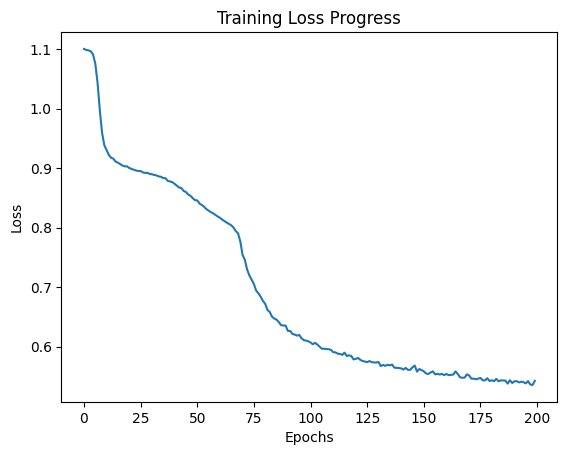

In [7]:
# Train the model
loss_values, accuracy_values = train_model(model, train_loader, criterion, optimizer, device=device, num_epochs=200)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.show()


 Unseen dataset Accuracy: 0.7446


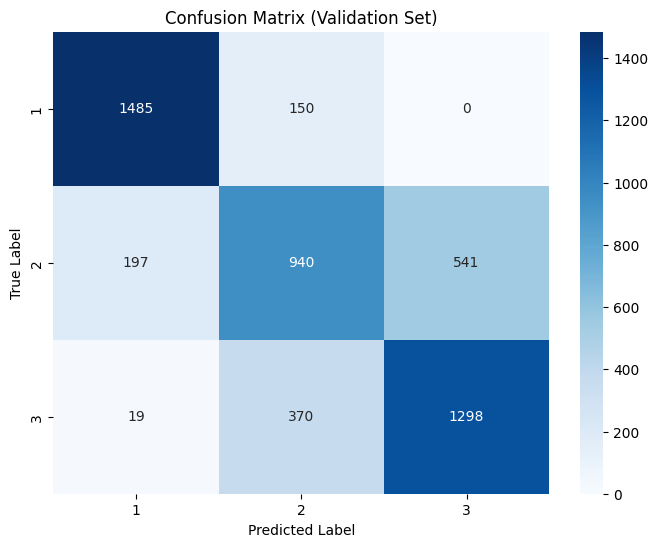

In [8]:
# Load the validation dataset
val_data = torch.load("Validation.pt", weights_only=False)

val_synthetic_data = val_data["synthetic_data"]         # shape: [N, 1024]
val_num_layers = val_data["num_layers"]                 # shape: [N]
val_num_layers_adjusted = val_num_layers - 1            # match training label indexing

# Unsqueeze to match model input shape
val_synthetic_data = val_synthetic_data.unsqueeze(1)    # shape: [N, 1, 1024]

# Create DataLoader for validation
val_dataset = TensorDataset(val_synthetic_data, val_num_layers_adjusted)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


model.eval()
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())   # move back to CPU before numpy
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix and accuracy
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

print(f"\n Unseen dataset Accuracy: {acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i+1}" for i in range(cm.shape[0])],
            yticklabels=[f"{i+1}" for i in range(cm.shape[0])])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

## Train and test Larger CNN

In [20]:
batch_size = 256

# Create TensorDataset with adjusted labels
train_dataset = TensorDataset(synthetic_data, num_layers_adjusted)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [21]:
# TODO: Learning rate annealing

# Initialize the model, criterion, and optimizer
model = CNN1D_Large(input_channels=1, num_classes=num_classes).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Optional: Print shapes and label stats for sanity check
print("Data shape:", synthetic_data.shape)
print("Label range:", num_layers_adjusted.min().item(), "to", num_layers_adjusted.max().item())
print("Number of classes:", num_classes)

Data shape: torch.Size([60000, 1, 1024])
Label range: 0 to 2
Number of classes: 3


Epoch 1/100: 100%|██████████| 235/235 [00:03<00:00, 60.34batch/s, loss=0.685]


Epoch [1/100], Loss: 0.6846


Epoch 2/100: 100%|██████████| 235/235 [00:03<00:00, 65.02batch/s, loss=0.413]


Epoch [2/100], Loss: 0.4132


Epoch 3/100: 100%|██████████| 235/235 [00:03<00:00, 61.70batch/s, loss=0.345]


Epoch [3/100], Loss: 0.3454


Epoch 4/100: 100%|██████████| 235/235 [00:03<00:00, 65.32batch/s, loss=0.308]


Epoch [4/100], Loss: 0.3085


Epoch 5/100: 100%|██████████| 235/235 [00:03<00:00, 64.34batch/s, loss=0.281]


Epoch [5/100], Loss: 0.2810


Epoch 6/100: 100%|██████████| 235/235 [00:03<00:00, 63.65batch/s, loss=0.266]


Epoch [6/100], Loss: 0.2662


Epoch 7/100: 100%|██████████| 235/235 [00:03<00:00, 63.44batch/s, loss=0.261]


Epoch [7/100], Loss: 0.2605


Epoch 8/100: 100%|██████████| 235/235 [00:03<00:00, 63.52batch/s, loss=0.24] 


Epoch [8/100], Loss: 0.2399


Epoch 9/100: 100%|██████████| 235/235 [00:03<00:00, 63.59batch/s, loss=0.236]


Epoch [9/100], Loss: 0.2360


Epoch 10/100: 100%|██████████| 235/235 [00:03<00:00, 63.03batch/s, loss=0.226]


Epoch [10/100], Loss: 0.2258


Epoch 11/100: 100%|██████████| 235/235 [00:03<00:00, 60.79batch/s, loss=0.219]


Epoch [11/100], Loss: 0.2190


Epoch 12/100: 100%|██████████| 235/235 [00:03<00:00, 63.11batch/s, loss=0.213]


Epoch [12/100], Loss: 0.2125


Epoch 13/100: 100%|██████████| 235/235 [00:03<00:00, 63.04batch/s, loss=0.207]


Epoch [13/100], Loss: 0.2071


Epoch 14/100: 100%|██████████| 235/235 [00:03<00:00, 63.77batch/s, loss=0.207]


Epoch [14/100], Loss: 0.2065


Epoch 15/100: 100%|██████████| 235/235 [00:03<00:00, 63.62batch/s, loss=0.202]


Epoch [15/100], Loss: 0.2020


Epoch 16/100: 100%|██████████| 235/235 [00:03<00:00, 64.14batch/s, loss=0.192]


Epoch [16/100], Loss: 0.1915


Epoch 17/100: 100%|██████████| 235/235 [00:03<00:00, 63.70batch/s, loss=0.198]


Epoch [17/100], Loss: 0.1984


Epoch 18/100: 100%|██████████| 235/235 [00:03<00:00, 63.78batch/s, loss=0.183]


Epoch [18/100], Loss: 0.1830


Epoch 19/100: 100%|██████████| 235/235 [00:03<00:00, 61.07batch/s, loss=0.19] 


Epoch [19/100], Loss: 0.1899


Epoch 20/100: 100%|██████████| 235/235 [00:03<00:00, 63.99batch/s, loss=0.188]


Epoch [20/100], Loss: 0.1876


Epoch 21/100: 100%|██████████| 235/235 [00:03<00:00, 63.82batch/s, loss=0.181]


Epoch [21/100], Loss: 0.1811


Epoch 22/100: 100%|██████████| 235/235 [00:03<00:00, 64.30batch/s, loss=0.182]


Epoch [22/100], Loss: 0.1817


Epoch 23/100: 100%|██████████| 235/235 [00:03<00:00, 64.03batch/s, loss=0.171]


Epoch [23/100], Loss: 0.1714


Epoch 24/100: 100%|██████████| 235/235 [00:03<00:00, 63.76batch/s, loss=0.169]


Epoch [24/100], Loss: 0.1689


Epoch 25/100: 100%|██████████| 235/235 [00:03<00:00, 63.70batch/s, loss=0.177]


Epoch [25/100], Loss: 0.1772


Epoch 26/100: 100%|██████████| 235/235 [00:03<00:00, 63.86batch/s, loss=0.17] 


Epoch [26/100], Loss: 0.1695


Epoch 27/100: 100%|██████████| 235/235 [00:03<00:00, 61.04batch/s, loss=0.168]


Epoch [27/100], Loss: 0.1682


Epoch 28/100: 100%|██████████| 235/235 [00:03<00:00, 64.01batch/s, loss=0.18] 


Epoch [28/100], Loss: 0.1805


Epoch 29/100: 100%|██████████| 235/235 [00:03<00:00, 63.79batch/s, loss=0.16] 


Epoch [29/100], Loss: 0.1601


Epoch 30/100: 100%|██████████| 235/235 [00:03<00:00, 63.59batch/s, loss=0.161]


Epoch [30/100], Loss: 0.1607


Epoch 31/100: 100%|██████████| 235/235 [00:03<00:00, 63.78batch/s, loss=0.159]


Epoch [31/100], Loss: 0.1589


Epoch 32/100: 100%|██████████| 235/235 [00:03<00:00, 63.90batch/s, loss=0.154]


Epoch [32/100], Loss: 0.1540


Epoch 33/100: 100%|██████████| 235/235 [00:03<00:00, 63.92batch/s, loss=0.155]


Epoch [33/100], Loss: 0.1553


Epoch 34/100: 100%|██████████| 235/235 [00:03<00:00, 64.29batch/s, loss=0.153]


Epoch [34/100], Loss: 0.1525


Epoch 35/100: 100%|██████████| 235/235 [00:03<00:00, 64.22batch/s, loss=0.152]


Epoch [35/100], Loss: 0.1515


Epoch 36/100: 100%|██████████| 235/235 [00:03<00:00, 60.71batch/s, loss=0.148]


Epoch [36/100], Loss: 0.1480


Epoch 37/100: 100%|██████████| 235/235 [00:03<00:00, 63.80batch/s, loss=0.146]


Epoch [37/100], Loss: 0.1460


Epoch 38/100: 100%|██████████| 235/235 [00:03<00:00, 64.01batch/s, loss=0.146]


Epoch [38/100], Loss: 0.1460


Epoch 39/100: 100%|██████████| 235/235 [00:03<00:00, 63.87batch/s, loss=0.15] 


Epoch [39/100], Loss: 0.1503


Epoch 40/100: 100%|██████████| 235/235 [00:03<00:00, 63.59batch/s, loss=0.147]


Epoch [40/100], Loss: 0.1467


Epoch 41/100: 100%|██████████| 235/235 [00:03<00:00, 62.79batch/s, loss=0.143]


Epoch [41/100], Loss: 0.1427


Epoch 42/100: 100%|██████████| 235/235 [00:03<00:00, 62.93batch/s, loss=0.142]


Epoch [42/100], Loss: 0.1424


Epoch 43/100: 100%|██████████| 235/235 [00:03<00:00, 62.70batch/s, loss=0.148]


Epoch [43/100], Loss: 0.1480


Epoch 44/100: 100%|██████████| 235/235 [00:03<00:00, 60.20batch/s, loss=0.136]


Epoch [44/100], Loss: 0.1363


Epoch 45/100: 100%|██████████| 235/235 [00:03<00:00, 63.48batch/s, loss=0.138]


Epoch [45/100], Loss: 0.1376


Epoch 46/100: 100%|██████████| 235/235 [00:03<00:00, 63.95batch/s, loss=0.14] 


Epoch [46/100], Loss: 0.1397


Epoch 47/100: 100%|██████████| 235/235 [00:03<00:00, 63.92batch/s, loss=0.136]


Epoch [47/100], Loss: 0.1363


Epoch 48/100: 100%|██████████| 235/235 [00:03<00:00, 63.84batch/s, loss=0.134]


Epoch [48/100], Loss: 0.1341


Epoch 49/100: 100%|██████████| 235/235 [00:03<00:00, 63.94batch/s, loss=0.138]


Epoch [49/100], Loss: 0.1382


Epoch 50/100: 100%|██████████| 235/235 [00:03<00:00, 64.34batch/s, loss=0.14] 


Epoch [50/100], Loss: 0.1400


Epoch 51/100: 100%|██████████| 235/235 [00:03<00:00, 64.05batch/s, loss=0.132]


Epoch [51/100], Loss: 0.1324


Epoch 52/100: 100%|██████████| 235/235 [00:03<00:00, 61.24batch/s, loss=0.127]


Epoch [52/100], Loss: 0.1266


Epoch 53/100: 100%|██████████| 235/235 [00:03<00:00, 64.06batch/s, loss=0.127]


Epoch [53/100], Loss: 0.1271


Epoch 54/100: 100%|██████████| 235/235 [00:03<00:00, 63.78batch/s, loss=0.129]


Epoch [54/100], Loss: 0.1292


Epoch 55/100: 100%|██████████| 235/235 [00:03<00:00, 62.57batch/s, loss=0.134]


Epoch [55/100], Loss: 0.1345


Epoch 56/100: 100%|██████████| 235/235 [00:03<00:00, 62.66batch/s, loss=0.129]


Epoch [56/100], Loss: 0.1292


Epoch 57/100: 100%|██████████| 235/235 [00:03<00:00, 63.19batch/s, loss=0.122]


Epoch [57/100], Loss: 0.1223


Epoch 58/100: 100%|██████████| 235/235 [00:03<00:00, 64.12batch/s, loss=0.129]


Epoch [58/100], Loss: 0.1292


Epoch 59/100: 100%|██████████| 235/235 [00:03<00:00, 64.85batch/s, loss=0.127]


Epoch [59/100], Loss: 0.1273


Epoch 60/100: 100%|██████████| 235/235 [00:03<00:00, 61.60batch/s, loss=0.121]


Epoch [60/100], Loss: 0.1208


Epoch 61/100: 100%|██████████| 235/235 [00:03<00:00, 62.55batch/s, loss=0.119]


Epoch [61/100], Loss: 0.1185


Epoch 62/100: 100%|██████████| 235/235 [00:03<00:00, 63.30batch/s, loss=0.123]


Epoch [62/100], Loss: 0.1226


Epoch 63/100: 100%|██████████| 235/235 [00:03<00:00, 63.54batch/s, loss=0.123]


Epoch [63/100], Loss: 0.1233


Epoch 64/100: 100%|██████████| 235/235 [00:03<00:00, 63.51batch/s, loss=0.118]


Epoch [64/100], Loss: 0.1178


Epoch 65/100: 100%|██████████| 235/235 [00:03<00:00, 63.10batch/s, loss=0.121]


Epoch [65/100], Loss: 0.1210


Epoch 66/100: 100%|██████████| 235/235 [00:03<00:00, 62.84batch/s, loss=0.123]


Epoch [66/100], Loss: 0.1229


Epoch 67/100: 100%|██████████| 235/235 [00:03<00:00, 62.84batch/s, loss=0.119]


Epoch [67/100], Loss: 0.1188


Epoch 68/100: 100%|██████████| 235/235 [00:03<00:00, 60.40batch/s, loss=0.114]


Epoch [68/100], Loss: 0.1137


Epoch 69/100: 100%|██████████| 235/235 [00:03<00:00, 62.61batch/s, loss=0.116]


Epoch [69/100], Loss: 0.1157


Epoch 70/100: 100%|██████████| 235/235 [00:03<00:00, 62.90batch/s, loss=0.11] 


Epoch [70/100], Loss: 0.1098


Epoch 71/100: 100%|██████████| 235/235 [00:03<00:00, 62.86batch/s, loss=0.113]


Epoch [71/100], Loss: 0.1131


Epoch 72/100: 100%|██████████| 235/235 [00:03<00:00, 62.41batch/s, loss=0.113]


Epoch [72/100], Loss: 0.1127


Epoch 73/100: 100%|██████████| 235/235 [00:03<00:00, 62.85batch/s, loss=0.113]


Epoch [73/100], Loss: 0.1125


Epoch 74/100: 100%|██████████| 235/235 [00:03<00:00, 63.28batch/s, loss=0.119]


Epoch [74/100], Loss: 0.1188


Epoch 75/100: 100%|██████████| 235/235 [00:03<00:00, 63.70batch/s, loss=0.111]


Epoch [75/100], Loss: 0.1112


Epoch 76/100: 100%|██████████| 235/235 [00:03<00:00, 60.86batch/s, loss=0.112]


Epoch [76/100], Loss: 0.1118


Epoch 77/100: 100%|██████████| 235/235 [00:03<00:00, 63.31batch/s, loss=0.113]


Epoch [77/100], Loss: 0.1133


Epoch 78/100: 100%|██████████| 235/235 [00:03<00:00, 62.33batch/s, loss=0.108]


Epoch [78/100], Loss: 0.1077


Epoch 79/100: 100%|██████████| 235/235 [00:03<00:00, 63.50batch/s, loss=0.107]


Epoch [79/100], Loss: 0.1072


Epoch 80/100: 100%|██████████| 235/235 [00:03<00:00, 62.51batch/s, loss=0.102] 


Epoch [80/100], Loss: 0.1019


Epoch 81/100: 100%|██████████| 235/235 [00:03<00:00, 63.26batch/s, loss=0.106]


Epoch [81/100], Loss: 0.1063


Epoch 82/100: 100%|██████████| 235/235 [00:03<00:00, 63.11batch/s, loss=0.114]


Epoch [82/100], Loss: 0.1138


Epoch 83/100: 100%|██████████| 235/235 [00:03<00:00, 62.99batch/s, loss=0.108]


Epoch [83/100], Loss: 0.1081


Epoch 84/100: 100%|██████████| 235/235 [00:03<00:00, 60.48batch/s, loss=0.105]


Epoch [84/100], Loss: 0.1053


Epoch 85/100: 100%|██████████| 235/235 [00:03<00:00, 62.89batch/s, loss=0.102] 


Epoch [85/100], Loss: 0.1019


Epoch 86/100: 100%|██████████| 235/235 [00:03<00:00, 63.16batch/s, loss=0.103]


Epoch [86/100], Loss: 0.1027


Epoch 87/100: 100%|██████████| 235/235 [00:03<00:00, 63.30batch/s, loss=0.0969]


Epoch [87/100], Loss: 0.0969


Epoch 88/100: 100%|██████████| 235/235 [00:03<00:00, 63.16batch/s, loss=0.106]


Epoch [88/100], Loss: 0.1056


Epoch 89/100: 100%|██████████| 235/235 [00:03<00:00, 62.85batch/s, loss=0.105]


Epoch [89/100], Loss: 0.1051


Epoch 90/100: 100%|██████████| 235/235 [00:03<00:00, 62.86batch/s, loss=0.104]


Epoch [90/100], Loss: 0.1037


Epoch 91/100: 100%|██████████| 235/235 [00:03<00:00, 63.22batch/s, loss=0.0984]


Epoch [91/100], Loss: 0.0984


Epoch 92/100: 100%|██████████| 235/235 [00:03<00:00, 60.47batch/s, loss=0.1]   


Epoch [92/100], Loss: 0.1002


Epoch 93/100: 100%|██████████| 235/235 [00:03<00:00, 63.66batch/s, loss=0.0992]


Epoch [93/100], Loss: 0.0992


Epoch 94/100: 100%|██████████| 235/235 [00:03<00:00, 62.96batch/s, loss=0.1]   


Epoch [94/100], Loss: 0.1004


Epoch 95/100: 100%|██████████| 235/235 [00:03<00:00, 62.56batch/s, loss=0.0993]


Epoch [95/100], Loss: 0.0993


Epoch 96/100: 100%|██████████| 235/235 [00:03<00:00, 62.48batch/s, loss=0.0983]


Epoch [96/100], Loss: 0.0983


Epoch 97/100: 100%|██████████| 235/235 [00:03<00:00, 62.47batch/s, loss=0.0986]


Epoch [97/100], Loss: 0.0986


Epoch 98/100: 100%|██████████| 235/235 [00:03<00:00, 63.13batch/s, loss=0.0949]


Epoch [98/100], Loss: 0.0949


Epoch 99/100: 100%|██████████| 235/235 [00:03<00:00, 63.37batch/s, loss=0.0917]


Epoch [99/100], Loss: 0.0917


Epoch 100/100: 100%|██████████| 235/235 [00:03<00:00, 60.36batch/s, loss=0.0987]


Epoch [100/100], Loss: 0.0987


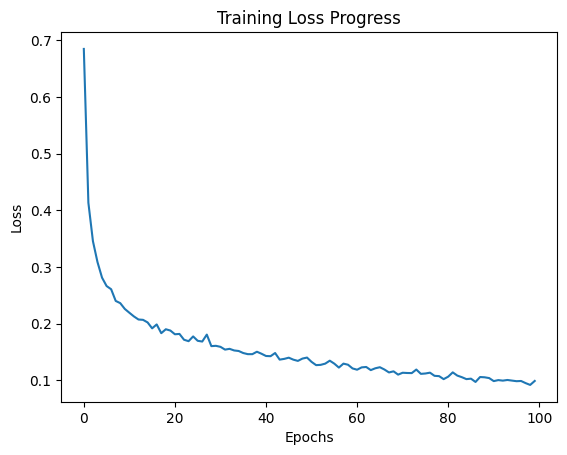

In [22]:
# Train the model
loss_values, accuracy_values = train_model(model, train_loader, criterion, optimizer, device=device, num_epochs=100)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.show()

In [12]:
# Load the validation dataset
val_data = torch.load("Validation.pt", weights_only=False)

val_synthetic_data = val_data["synthetic_data"]         # shape: [N, 1024]
val_num_layers = val_data["num_layers"]                 # shape: [N]
val_num_layers_adjusted = val_num_layers - 1            # match training label indexing

# Unsqueeze to match model input shape
val_synthetic_data = val_synthetic_data.unsqueeze(1)    # shape: [N, 1, 1024]

# Create DataLoader for validation
val_dataset = TensorDataset(val_synthetic_data, val_num_layers_adjusted)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())   # move back to CPU before numpy
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix and accuracy
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

print(f"\nUnseen Accuracy: {acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i+1}" for i in range(cm.shape[0])],
            yticklabels=[f"{i+1}" for i in range(cm.shape[0])])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Unseen Set)")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Validation.pt'